In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import pydub
import sounddevice as sd
from matplotlib import pyplot as plt
from scipy.io.wavfile import read, write

In [124]:
img = cv.imread("Polye.png", cv.IMREAD_GRAYSCALE)

In [127]:
def detectLines(img):
    dst = cv.Canny(img, 50, 200, None, 3)

    cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)

    linesP = cv.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)

    lines_x = []
    lines_y = []

    for i in range(0, len(linesP)):
        l = linesP[i][0]

        if (abs(l[0] - l[2]) <= 1):
            continue

        if (lines_x == [] or lines_y == []):
            lines_x.append(l[0])
            lines_y.append(l[1])

        if (abs(lines_y[-1] - l[1]) < 1):
            continue
        else:
            lines_x.append(l[0])
            lines_y.append(l[1])

    lines_x = np.asarray(lines_x)
    lines_y = np.asarray(lines_y)

    index = np.argsort(lines_y)
    lines_x = lines_x[index]
    lines_y = lines_y[index]

    diff = np.diff(lines_y)
    indices_toKeep = [0]
    for i in range(diff.shape[-1]):
        if (diff[i] > 5):
            indices_toKeep.append(i+1)

    lines_x = lines_x[indices_toKeep]
    lines_y = lines_y[indices_toKeep]
    lines_y[4] -= 1
    lines_y = np.delete(lines_y, [5, 11])
    
    for i in range(lines_y.shape[-1]):
        cv.line(cdst, (0, lines_y[i]), (1740, lines_y[i]), (0,0,255), 3, cv.LINE_AA)
    
    return lines_x, lines_y, cdst

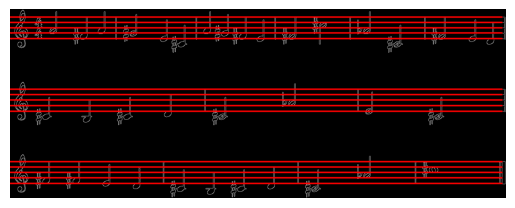

In [128]:
lines_x, lines_y, cdst = detectLines(img)

_ = plt.imshow(cdst[:,:,(2,1,0)])
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.box(0)

In [129]:
    def detectNotes(img, template, threshold, dur, down):
        img2 = img.copy()

        w, h = template.shape[::-1]

        res = cv.matchTemplate(img, template, cv.TM_CCOEFF_NORMED)
        loc = np.where( res >= threshold)

        rects = list(zip(*loc[::-1], loc[0].shape[0]*[dur], loc[0].shape[0]*[0]))
        rects = sorted(rects, key = lambda x: (x[0], x[1]))
        rects = np.asarray(rects)

        keep = [0]
        x_margin = 20
        y_margin = 20
        prev_x = rects[0][0]
        prev_y = rects[0][1]

        for i in range(1, rects.shape[0]):
            for j in range(0, i):
                if (abs(rects[i][0] - rects[j][0]) < x_margin and abs(rects[i][1] - rects[j][1]) < y_margin):
                    break;
            else:
                keep.append(i)

        rects = rects[keep]

        for pt in rects:
            cv.rectangle(img2, pt[0:2], (pt[0] + w, pt[1] + h), (0,0,255), 2)

        rects = rects + [0 if (dur != -1 and dur != -2) else w, h - 7 if dur == 4 else (h - 11 if down == 0 else 11), 0, 0]

        return rects, img2

    def attachNotes(rectsQ, rectsH, rectsW, rectsH2):
        rects = np.ndarray.tolist(rectsQ)
        rects.extend(np.ndarray.tolist(rectsH))
        rects.extend(np.ndarray.tolist(rectsW))
        rects.extend(np.ndarray.tolist(rectsH2))

        rects = sorted(rects, key = lambda x: (x[0], x[1]))

        rects = np.asarray(rects)

        return rects

    def attachExtensions(rectsS, rectsF):
        rects = np.ndarray.tolist(rectsS)
        rects.extend(np.ndarray.tolist(rectsF))

        rects = sorted(rects, key = lambda x: (x[0], x[1]))

        rects = np.asarray(rects)

        return rects

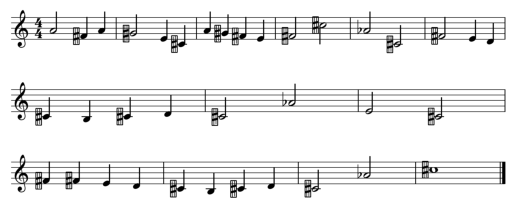

In [137]:
template1 = cv.imread("quarter.PNG", cv.IMREAD_GRAYSCALE)
template2 = cv.imread("half.PNG", cv.IMREAD_GRAYSCALE)
template3 = cv.imread("whole.PNG", cv.IMREAD_GRAYSCALE)
template4 = cv.imread("half2.PNG", cv.IMREAD_GRAYSCALE)
template5 = cv.imread("sharp.PNG", cv.IMREAD_GRAYSCALE)
template6 = cv.imread("flat.PNG", cv.IMREAD_GRAYSCALE)

thresholdQ = 0.77
thresholdH = 0.75
thresholdW = 0.5
thresholdS = 0.7
thresholdF = 0.7

rectsQ, imgQ = detectNotes(img, template1, thresholdQ, 4, 0)
rectsH, imgH = detectNotes(img, template2, thresholdH, 2, 0)
rectsW, imgW = detectNotes(img, template3, thresholdW, 0, 0)
rectsH2, imgH2 = detectNotes(img, template4, thresholdH, 2, 1)
rectsS, imgS = detectNotes(img, template5, thresholdS, -1, 0)
rectsF, imgF = detectNotes(img, template6, thresholdF, -2, 0)

rects = attachNotes(rectsQ, rectsH, rectsW, rectsH2)
rectsExt = attachExtensions(rectsS, rectsF)

_ = plt.imshow(imgS, cmap = plt.cm.gray)
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.box(0)

In [144]:
def compile_music(rects, rectsExt):
    section_frontiers = [(lines_y[4] + lines_y[5])/2,(lines_y[9] + lines_y[10])/2] 

    notes1 = []
    notes2 = []
    notes3 = []

    extensions1 = []
    extensions2 = []
    extensions3 = []

    for rect in rects:
        if (rect[1] < section_frontiers[0]):
            notes1.append((rect[0], rect[1], rect[2], rect[3]))
        elif (rect[1] > section_frontiers[0] and rect[1] < section_frontiers[1]):
            notes2.append((rect[0], rect[1], rect[2], rect[3]))
        else:
            notes3.append((rect[0], rect[1], rect[2], rect[3]))

    notes1 = np.asarray(notes1)
    notes2 = np.asarray(notes2)
    notes3 = np.asarray(notes3)

    for rect in rectsExt:
        if (rect[1] < section_frontiers[0]):
            extensions1.append((rect[0], rect[1], rect[2], rect[3]))
        elif (rect[1] > section_frontiers[0] and rect[1] < section_frontiers[1]):
            extensions2.append((rect[0], rect[1], rect[2], rect[3]))
        else:
            extensions3.append((rect[0], rect[1], rect[2], rect[3]))

    for ext in extensions1:
        diffs = abs(notes1[:,0] - ext[0])
        whichNote = np.argsort(diffs)[0]

        if (ext[2] == -1):
            notes1[whichNote, 3] = 1
        else:
            notes1[whichNote, 3] = -1

    for ext in extensions2:
        diffs = abs(notes2[:,0] - ext[0])
        whichNote = np.argsort(diffs)[0]

        if (ext[2] == -1):
            notes2[whichNote, 3] = 1
        else:
            notes2[whichNote, 3] = -1

    for ext in extensions3:
        diffs = abs(notes3[:,0] - ext[0])
        whichNote = np.argsort(diffs)[0]

        if (ext[2] == -1):
            notes3[whichNote, 3] = 1
        else:
            notes3[whichNote, 3] = -1

    section1 = np.asarray(lines_y[0:5])
    section2 = np.asarray(lines_y[5:10])
    section3 = np.asarray(lines_y[10:15])

    onLine_margin = 4
    betweenLine_margin = 10
    C_D_boundary = 15
    C_B_boundary = 25

    music_lines = []

    for note in notes1:
        diffs = abs(section1 - note[1])
        potentials = np.argsort(diffs)

        if (diffs[potentials[0]] <= onLine_margin):
            music_lines.append((potentials[0] + 1, note[3], note[2]))
        elif (diffs[potentials[0]] <= betweenLine_margin):
            if (diffs[potentials[1]] <= 2 * betweenLine_margin):
                music_lines.append(((potentials[0] + potentials[1])/2 + 1, note[3], note[2]))
            else:
                music_lines.append((5.5, note[3], note[2]))
        elif (diffs[potentials[0]] <= C_D_boundary):
            music_lines.append((5.5, note[3], note[2]))
        elif (diffs[potentials[0]] <= C_B_boundary):
            music_lines.append((6, note[3], note[2]))
        else:
            music_lines.append((6.5, note[3], note[2]))

    for note in notes2:
        diffs = abs(section2 - note[1])
        potentials = np.argsort(diffs)

        if (diffs[potentials[0]] <= onLine_margin):
            music_lines.append((potentials[0] + 1, note[3], note[2]))
        elif (diffs[potentials[0]] <= betweenLine_margin):
            if (diffs[potentials[1]] <= 2 * betweenLine_margin):
                music_lines.append(((potentials[0] + potentials[1])/2 + 1, note[3], note[2]))
            else:
                music_lines.append((5.5, note[3], note[2]))
        elif (diffs[potentials[0]] <= C_D_boundary):
            music_lines.append((5.5, note[3], note[2]))
        elif (diffs[potentials[0]] <= C_B_boundary):
            music_lines.append((6, note[3], note[2]))
        else:
            music_lines.append((6.5, note[3], note[2]))

    for note in notes3:
        diffs = abs(section3 - note[1])
        potentials = np.argsort(diffs)

        if (diffs[potentials[0]] <= onLine_margin):
            music_lines.append((potentials[0] + 1, note[3], note[2]))
        elif (diffs[potentials[0]] <= betweenLine_margin):
            if (diffs[potentials[1]] <= 2 * betweenLine_margin):
                music_lines.append(((potentials[0] + potentials[1])/2 + 1, note[3], note[2]))
            else:
                music_lines.append((5.5, note[3], note[2]))
        elif (diffs[potentials[0]] <= C_D_boundary):
            music_lines.append((5.5, note[3], note[2]))
        elif (diffs[potentials[0]] <= C_B_boundary):
            music_lines.append((6, note[3], note[2]))
        else:
            music_lines.append((6.5, note[3], note[2]))

    compiled_music = []

    for note in music_lines:
        if (note[0] == 6.5):
            compiled_music.append([2 + note[1], 3, note[2]])
        elif (note[0] == 6):
            compiled_music.append([3 + note[1], 4, note[2]])
        elif (note[0] == 5.5):
            compiled_music.append([5 + note[1], 4, note[2]])
        elif (note[0] == 5):
            compiled_music.append([7 + note[1], 4, note[2]])
        elif (note[0] == 4.5):
            compiled_music.append([8 + note[1], 4, note[2]])
        elif (note[0] == 4):
            compiled_music.append([10 + note[1], 4, note[2]])
        elif (note[0] == 3.5):
            if (note[1] == -1):
                compiled_music.append([11, 4, note[2]])
            else:
                compiled_music.append([note[1], 4, note[2]])
        elif (note[0] == 3):
            compiled_music.append([2 + note[1], 4, note[2]])
        elif (note[0] == 2.5):
            compiled_music.append([3 + note[1], 5, note[2]])
            
    return compiled_music

In [139]:
compiled_music = compile_music(rects, rectsExt)

In [140]:
def getDurations(tempo, fs):
    whole_note = 4*60*fs/tempo
    durs = np.array([[whole_note/(2**i),dotted(whole_note/(2**i))] for i in range(6)])
    
    return durs.flatten()

def dotted(dur):
    return dur*1.5

def sin_wave(f, n, fs):
    x = np.linspace(0, 2*np.pi, n)
    xp = np.linspace(0, -1*(n*ring/fs), n)
    y = np.sin(x*f*(n/fs))*np.exp(xp)
    z = np.zeros([n, 2])
    z[:, 0] = y
    z[:, 1] = y
    return z

def play_note(note_id, octave, dur, fs):
    if (note_id < 3) :
        octave += 1
    y = sin_wave(notes_base[note_id]*2**octave, int(notes_duration[dur]), fs)
    sd.play(y, fs)
    sd.wait()
    return 

def put_note(note_id, octave, dur, fs):
    if (note_id < 3) :
        octave += 1
    y = sin_wave(notes_base[note_id]*2**octave, int(notes_duration[dur]), fs)
    return y

def get_music(music_notes, fs):
    m = []
    for item in music_notes:
        y = put_note(item[0], item[1], item[2], fs)
        m.append(y)
    m = np.concatenate(m, 0)
    return m

In [141]:
notes_base = 2**(np.arange(12)/12)*27.5 # A0; A4= 440 Hz
tempo = 120
ring = 3 # how long the sine wave rings. lower value = more ringing/sustain
fs = 44100
notes_duration = getDurations(tempo,fs)
"""
    Whole note = 0
    Dotted whole note = 1
    Half note = 2
    Dotted half note = 3
    Quarter note = 4
    Dotted quarter note = 5
    etc.
"""
notes_ann = ['A', 'A#', 'B', 'C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#']

polye = compiled_music

y = get_music(polye, fs)
sd.play(y, fs)

In [142]:
write("polye.wav", fs, y.astype(np.float32))